## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

## 2  — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve each idiom containing the word.
Add the idiom Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-idiom match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## 5 — Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10 and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [ ]:
# """
# In jupyter notebook simple logging to console
# """
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

# # Test
# logger = logging.getLogger('LOGGER_NAME')

# logger.debug('This is hidden')
# logger.info('So this is shown on the console')
# logger.warning('This too')

In [9]:
import pandas as pd
from collections import namedtuple
import uuid

## -1  — Webscrape and process phrases (idioms, sayings, aphorisms)

They should be converted into lists of phonetic sounds

## 0  — Load `phrase_dict` pickled and processed after being scraped

#### Data structures defined

In [251]:
Phrase = namedtuple('Phrase',['text_string', 'word_list','phon_list','string_length', 'word_count', 'prefix', 'phrase_type'])

Close_word = namedtuple('Close_word', ['word', 'distance'])
Sem_family = namedtuple('Sem_family', ['locus_word', 'sem_fam_words'])
Phon_family = namedtuple('Phon_family', ['locus_word', 'close_words'])

#### Temporary toy example of the dict of phrases, to be replaced with idioms etc. scraped from web

In [252]:
def seed_the_phrase_dictionary_with_examples(phrase_dict_ ):
    t_string = 'smarter than the average bear'
    w_list = t_string.lower().split()
    ph_id1 = uuid.uuid1()
    phrase_dict_[ph_id1] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'not a hair out of place'
    w_list = t_string.lower().split()
    ph_id2 = uuid.uuid1()
    phrase_dict_[ph_id2] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'three blind mice'
    w_list = t_string.lower().split()
    ph_id3 = uuid.uuid1()
    phrase_dict_[ph_id3] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    # toy example of the dict
    t_string = 'i just called to say I love you'
    w_list = t_string.lower().split()
    ph_id4 = uuid.uuid1()
    phrase_dict_[ph_id4] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'up, up in the air'
    w_list = t_string.lower().split()
    ph_id5 = uuid.uuid1()
    phrase_dict_[ph_id5] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'wouldn\'t it be nice'
    w_list = t_string.lower().split()
    ph_id6 = uuid.uuid1()
    phrase_dict_[ph_id6] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

    t_string = 'roses are red, violets are blue'
    w_list = t_string.lower().split()
    ph_id7 = uuid.uuid1()
    phrase_dict_[ph_id7] = Phrase(text_string = t_string, word_list = w_list, phon_list = w_list, string_length = len(t_string), word_count = len(w_list), prefix="As usual: ", phrase_type='idiom' )

#seed_the_phrase_dictionary_with_examples()

In [253]:
# change this so that it imports into a pandas dataframe, so that we can import conversational 
# prefixes and suffixes manually editied in Excel

import csv

def compile_idiom_lists():
    idiom_list_ = []
    with open('data/idioms_1500.csv', 'r') as idioms_data: 
        for line in csv.reader(idioms_data):
            idiom_list_.extend(line)
    idiom_list_ = idiom_list_[1:]
    return idiom_list_
    
#idiom_list = compile_idiom_lists()


In [254]:
import pickle
   

## 1 — Recognize objects in image (or classify image)

Using trained NN, get object label or labels for image, or otherwise provide a label for the image. Also store the centrality of the object. 

In [255]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tf_explain.core.activations import ExtractActivations
from tensorflow.keras.applications.xception import decode_predictions


#%matplotlib inline

In [256]:
def load_image_classification_model():
    model_ = tf.keras.applications.xception.Xception(weights = 'imagenet', include_top=True)
    return model_

import requests
def get_image_category_labels():  # is this function even necessary?
    #fetching labels from Imagenet
    response=requests.get('https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json')
    imgnet_map=response.json()
    #imgnet_map   # {'0': ['n01440764', 'tench'],   '1': ['n01443537', 'goldfish'], etc.
    
    imgnet_num_from_label = {v[1]:k for k, v in imgnet_map.items()}
    imgnet_label_from_num = {k:v[1] for k, v in imgnet_map.items()}

    return ( imgnet_num_from_label, imgnet_label_from_num ) 

#model = prepare_image_classification_model()

In [257]:
import re
import csv

def get_curated_img_label_dict():    
    img_label_dict = {}

    with open('data/image_net_labels_with_original_index_numbers.txt', newline = '') as labels:                                                                                          
        label_reader = csv.reader(labels, delimiter=' ')
        for label_row in label_reader:
            img_label_dict[label_row[0]] = label_row[2]
            #img_label_dict        
             

#     filepath = 'data/imagenet1000_clsidx_to_labels.txt'
#     with open(filepath) as fp:
#         line = fp.readline()
#         cnt = 0
#         pattern = re.compile('([^\s\w]|_)+')
#         while line:
#             cleaner_line = re.sub(r'^"', '', line, flags=re.I)
#             cleaner_line = re.sub(r'^\"{', '', line, flags=re.I)
#             cleaner_line = re.sub(r'"$', '', cleaner_line, flags=re.I)
#             # cleaner_line = re.sub(r'}$', '', cleaner_line, flags=re.I)
#             label_string = cleaner_line.split(':')[1]
#             stripped_string = pattern.sub('', label_string)
#             stripped_string_list = stripped_string.split()
#             img_label_dict[cnt] = stripped_string_list
#             line=fp.readline()
#             cnt+=1

    return img_label_dict

#img_label_dict = get_curated_img_label_dict()

In [258]:
def get_num_str( num, max_digits=4 ):
    leading_zeros = int(max_digits - (np.trunc(np.log10(num))+1))
    return '0'*leading_zeros + str(num)

In [259]:
import random

def get_image_path(img_num):
    path_prefix = 'data/ILSVRC/Data/DET/test/'
    filename_stem ='ILSVRC2017_test_0000'
    filename_suffix = '.JPEG'
    #file_number = rand_num = np.random.randint(1, 5500)   
    IMAGE_PATH_ = path_prefix + filename_stem + get_num_str( img_num ) + filename_suffix
    return IMAGE_PATH_
    
def preprocess_image( IMAGE_PATH_ ):
    img_ =tf.keras.preprocessing.image.load_img(IMAGE_PATH_, target_size=(299, 299))
    img_ =tf.keras.preprocessing.image.img_to_array(img_)
    # prepare to show and save image
    ax = plt.axes([0,0,1,1], frameon=False)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.autoscale(tight=True)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(img_/255.)
    plt.savefig('data/temp.png',bbox_inches='tight')
    return img_ # It seems futile to return this image

def process_and_classify_image( img_, model_):
    img_ = tf.keras.applications.xception.preprocess_input(img_)
    #print( 'img.shape: ', img_.shape )
    prediction_array = model_.predict(np.array([img_]))
    return prediction_array

def extract_best_prediction(img_label_dict_, prediction_array_ ):
    prediction_decoded = decode_predictions(prediction_array_, top=1)
    #print( prediction_decoded[0][0][0] )
#   best_prediction_str = prediction_decoded[0][0][1]
    best_prediction_str = img_label_dict_[ prediction_decoded[0][0][0] ]
    #print(best_prediction_str)
    return best_prediction_str
#    

    

In [260]:
#!pwd

In [347]:
import pickle
import streamlit as st

#@st.cache(show_spinner=False)
def image_recognition_pipeline( model_,  img_label_dict_, img_num = np.random.randint(1, 5500)):
    #model_ = prepare_image_classification_model()
    IMAGE_PATH = get_image_path( img_num )
    img = preprocess_image( IMAGE_PATH )
    prediction_array = process_and_classify_image( img, model_)
    # image_topic_ = extract_best_prediction( img_label_dict_, prediction_array )
    # image_topics_ = [image_topic_]
    image_topics_  = extract_best_prediction( img_label_dict_, prediction_array )
    with open("data/" + "image_topics.pickle", 'wb') as to_write:
        pickle.dump([image_topics_], to_write)
      
    return  img, [image_topics_]

#image_recognition_pipeline(model, img_label_dict )

#model = prepare_image_classification_model()
#img, image_topics = image_recognition_pipeline(model, img_label_dict )
# image_topics

In [401]:
import gensim
from gensim.models import Word2Vec


#@st.cache (show_spinner=False)
def load_w2v_kv_model():
    glove_file = glove_dir  = 'data/glove.6B/glove.6B.100d.txt'

    w2v_output_file = 'data/glove.6B/glove.6B.100d.txt.w2v'
    gensim.scripts.glove2word2vec.glove2word2vec(glove_file, w2v_output_file)
    # Now we can load it!
    model = gensim.models.KeyedVectors.load_word2vec_format(w2v_output_file, binary=False)
    return model

#load_w2v_kv_model()

In [522]:
# import gensim.downloader as api
# corpus = api.load("text8")
# from gensim.models.word2vec import Word2Vec
# model_skp = Word2Vec(corpus, sg=1)
# model_bow = Word2Vec(corpus, sg=0)
# model_skp.wv.save_word2vec_format('data/model_skp.bin', binary=True)
# model_bow.wv.save_word2vec_format('data/model_bow.bin', binary=True)
# with open('data/model_bow.pickle','wb') as fout:
#     pickle.dump(model_bow, fout)
# with open('data/model_skp.pickle','wb') as fout:
#     pickle.dump(model_skp, fout)

2021-03-21 21:03:45.785 INFO    gensim.models.word2vec: collecting all words and their counts
2021-03-21 21:03:45.788 INFO    gensim.models.word2vec: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-21 21:03:50.121 INFO    gensim.models.word2vec: collected 253854 word types from a corpus of 17005207 raw words and 1701 sentences
2021-03-21 21:03:50.121 INFO    gensim.models.word2vec: Loading a fresh vocabulary
2021-03-21 21:03:50.390 INFO    gensim.models.word2vec: effective_min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
2021-03-21 21:03:50.390 INFO    gensim.models.word2vec: effective_min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
2021-03-21 21:03:50.555 INFO    gensim.models.word2vec: deleting the raw counts dictionary of 253854 items
2021-03-21 21:03:50.563 INFO    gensim.models.word2vec: sample=0.001 downsamples 38 most-common words
2021-03-21 21:03:50.563 INFO    gensim.models.word2vec: downsa

2021-03-21 21:04:47.709 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 57.08% examples, 414743 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:48.715 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 60.44% examples, 414977 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:49.724 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 63.73% examples, 414677 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:50.751 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 66.78% examples, 412530 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:51.754 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 70.14% examples, 412837 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:52.757 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 73.49% examples, 413202 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:53.782 INFO    gensim.models.base_any2vec: EPOCH 2 - PROGRESS: at 76.95% examples, 413002 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:04:54.

2021-03-21 21:05:41.961 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 37.15% examples, 417665 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:42.997 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 40.51% examples, 416539 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:44.033 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 43.86% examples, 415693 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:45.034 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 47.21% examples, 416118 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:46.035 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 50.62% examples, 416930 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:47.049 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 53.91% examples, 416320 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:48.057 INFO    gensim.models.base_any2vec: EPOCH 4 - PROGRESS: at 57.20% examples, 415949 words/s, in_qsize 5, out_qsize 0
2021-03-21 21:05:49.

2021-03-21 21:06:35.039 INFO    gensim.models.word2vec: Loading a fresh vocabulary
2021-03-21 21:06:35.192 INFO    gensim.models.word2vec: effective_min_count=5 retains 71290 unique words (28% of original 253854, drops 182564)
2021-03-21 21:06:35.193 INFO    gensim.models.word2vec: effective_min_count=5 leaves 16718844 word corpus (98% of original 17005207, drops 286363)
2021-03-21 21:06:35.333 INFO    gensim.models.word2vec: deleting the raw counts dictionary of 253854 items
2021-03-21 21:06:35.339 INFO    gensim.models.word2vec: sample=0.001 downsamples 38 most-common words
2021-03-21 21:06:35.341 INFO    gensim.models.word2vec: downsampling leaves estimated 12506280 word corpus (74.8% of prior 16718844)
2021-03-21 21:06:35.541 INFO    gensim.models.base_any2vec: estimated required memory for 71290 words and 100 dimensions: 92677000 bytes
2021-03-21 21:06:35.541 INFO    gensim.models.word2vec: resetting layer weights
2021-03-21 21:06:45.097 INFO    gensim.models.base_any2vec: trainin

2021-03-21 21:07:24.536 INFO    gensim.models.base_any2vec: EPOCH 5 - PROGRESS: at 60.38% examples, 1511350 words/s, in_qsize 0, out_qsize 0
2021-03-21 21:07:25.536 INFO    gensim.models.base_any2vec: EPOCH 5 - PROGRESS: at 72.43% examples, 1511204 words/s, in_qsize 1, out_qsize 0
2021-03-21 21:07:26.540 INFO    gensim.models.base_any2vec: EPOCH 5 - PROGRESS: at 84.60% examples, 1509286 words/s, in_qsize 0, out_qsize 0
2021-03-21 21:07:27.540 INFO    gensim.models.base_any2vec: EPOCH 5 - PROGRESS: at 96.65% examples, 1508403 words/s, in_qsize 0, out_qsize 0
2021-03-21 21:07:27.820 INFO    gensim.models.base_any2vec: worker thread finished; awaiting finish of 2 more threads
2021-03-21 21:07:27.822 INFO    gensim.models.base_any2vec: worker thread finished; awaiting finish of 1 more threads
2021-03-21 21:07:27.824 INFO    gensim.models.base_any2vec: worker thread finished; awaiting finish of 0 more threads
2021-03-21 21:07:27.825 INFO    gensim.models.base_any2vec: EPOCH - 5 : training o

In [525]:
#@st.cache (show_spinner=False)
def load_w2v_models():
    from gensim.models.word2vec import Word2Vec

    #model_skp_ = gensim.models.Word2Vec.load('data/model_skp.bin')
    #model_bow_ = gensim.models.Word2Vec.load('data/model_bow.bin')
    with open("data/model_bow.pickle", mode='rb') as model_data:
         model_bow_ = pickle.load(model_data)
    with open("data/model_bow.pickle", mode='rb') as model_data:
         model_skp_ = pickle.load(model_data)
            
    #glove_file = glove_dir  = 'data/glove.6B/glove.6B.100d.txt'

    return model_bow_, model_skp_

load_w2v_models()

(<gensim.models.word2vec.Word2Vec at 0x7fcdf281cc70>,
 <gensim.models.word2vec.Word2Vec at 0x7fcdf281ce20>)

## 2 — Generate semantic word families

For each label, use Word2Vec `similar` to retrieve list of words semantically related to the image object labels

In [263]:
from nltk.corpus import wordnet

def get_synonyms( w ):
   # L = [l.name() if '_' not in l.name() else l.name().split('_') for l in wordnet.synsets( w )[0].lemmas()]  # There may be other synonyms in the synset
   # print(L)
    #flattened_list = [w if type()]
    #return L #flattened_list
    syn_list = []
    try:
        syn_list = [word.split('.')[0] for object_name in \
                                    [syn.name().split('_') for syn in wordnet.synsets( w )[0].hypernyms() ] \
                                    for word in object_name if (('_' not in w) or (word.split('.')[0] != w.split('_')[-1]))]
    except:
        pass
            
#    L_set = set(L)
#    syn_list_set = set(syn_list)
#    unn = ( L_set | syn_list )                  
#    syn_list = list(  set(syn_list) | set(L) )    
#              list(  set(lst1)     | set(lst2)   )
    #syn_list.extend([word.split('.')[0] for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].lemmas() ] for word in object_name])
    #syn_list=[word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].hypernyms()[0].hyponyms() ] for word in object_name]
    #syn_list.extend([word for object_name in [syn.name().split('_') for syn in wordnet.synsets( w )[0].root_hypernyms()] for word in object_name])
 
    return syn_list



In [264]:
#'bird.n.01'.split('.')[0]

## 3 — Generate all related words

For each semantically related (below a distance threshold) word to each object label, measure its phonetic similarity to all words in the dictionary. Also store each words's distance.

For each word in each semantic family, sort and choose the phonetically closest (below a distance threshold) words.
(One way is to convert the word to IPA and compare to an IPA converted version of every word in the CMU dictionary.)

In [265]:
from nltk.corpus import words

words_set = set( words.words())

In [266]:
import eng_to_ipa as ipa
import pronouncing as pron
import syllables

def syllable_count_diff( w1, w2, syllable_count_dict_ ): 
    if w2 not in syllable_count_dict_.keys():
        try:
            syllable_count_dict_[w2] = syllables.estimate(w2)
        except:
            try:
                syllable_count_dict_[w2] = ipa.syllable_count(w2)
            except:
                try:
                    syllable_count_dict_[w2] = pron.syllablle_count(pron.get_phones_for_word( w2 )[0])
                except:
                    return 0
    if w1 not in syllable_count_dict_.keys():
        try:
            syllable_count_dict_[w1] = syllables.estimate(w1)
        except:
            try:
                syllable_count_dict_[w1] = ipa.syllable_count(w1)
            except:
                try:
                    syllable_count_dict_[w1] = pron.syllablle_count(pron.get_phones_for_word( w1 )[0])
                except:
                    return 0   

    return abs( syllable_count_dict_[ w1 ] - syllable_count_dict_[ w2 ])
    #return pron.syllable

def same_syllable_count( w1, w2, syllable_count_dict_  ):
    return syllable_count_diff(w1, w2, syllable_count_dict_ ) == 0

def close_syllable_count( w1, w2, syllable_count_dict_, threshold=2):
    return syllable_count_diff( w1, w2, syllable_count_dict_ ) <= threshold

In [267]:
#pron.syllable_count(pron.phones_for_word("delinquent")[0])

In [268]:
# Eventually will need to to filter for the word-frequency sweet-spot or at least for only Engllish words
# Possibly rewrite with a decororater so that it uses memoization to speed this up

# Rewrite this so it vectorizes the subtraction of the syllable counts

def get_sized_rhymes( w, syllable_count_dict_ ):
    word_length_min = 2
    rhyme_list = pron.rhymes( w )
    #print(rhyme_list)
    #rhyme_list = ipa.get_rhymes( w )
    return [ [rhyme for rhyme  in rhyme_list if close_syllable_count( w, rhyme, syllable_count_dict_, 1) and len(rhyme) >= word_length_min ]]
    #return [ [rhyme for rhyme  in rhyme_list if close_syllable_count( w, rhyme, syllable_count_dict_, 1) and len(rhyme) >= word_length_min and rhyme in words_set]]
    #return [ [rhyme for rhyme  in rhyme_list if len(rhyme) >= word_length_min and rhyme in words_set]]
 

In [269]:
# pron.rhymes('studio')
# syllable_count_dict_ = dict({'studio': 3})
# get_sized_rhymes('studio', syllable_count_dict_ )
#syllable_count_dict_['studio'] = 3

In [270]:
import fuzzy
import phonetics
import Levenshtein as lev

#soundex = fuzzy.Soundex(4)
dmeta = fuzzy.DMetaphone()

In [271]:
import eng_to_ipa as ipa


def syllable_penalty(w1, w2, syllable_count_dict_, penalty_factor = 0.2):

    return syllable_count_diff( w1, w2, syllable_count_dict_ ) * penalty_factor

In [532]:
def first_letter_discount(w1, w2, discount_value = .4):
    return discount_value if w1[0] == w2[0] else 0

def last_letter_discount(w1, w2, discount_value = .5): # was .3
    return discount_value if w1[-1] == w2[-1] else 0

In [273]:
def phonetic_distance(w1, w2, fuzzy_meta_dict_, fuzzy_nysiis_dict_):
#     print('fuzzy soundex', lev.distance( soundex(w1), soundex(w2)) )
#     print('fuzzy dmeta  ', lev.distance( dmeta(w1)[0], dmeta(w2)[0]) )
#     print('phon dmet    ', lev.distance( phonetics.dmetaphone(w1)[0], phonetics.dmetaphone(w2)[0]) )
#     print('phon met     ', lev.distance( phonetics.metaphone(w1), phonetics.metaphone(w2)) )
#     print('fuzzy nysiis ', lev.distance( fuzzy.nysiis(w1), fuzzy.nysiis(w2)) )
#     print('phon nysiis  ', lev.distance( phonetics.nysiis(w1), phonetics.nysiis(w2)) )
#     soundex_dist = lev.distance( soundex(w1), soundex(w2))
    num_of_measures = 1
    sum_of_measures = 0
    if w2 not in words_set:
        fuzzy_nysiis_dict_[w2] = fuzzy.nysiis(w2)
        fuzzy_meta_dict_[w2] = dmeta(w2)[0]
        
    nysiis_dist = lev.distance( fuzzy_nysiis_dict_[w1],fuzzy_nysiis_dict_[w2])
    num_of_measures +=1
    sum_of_measures+= nysiis_dist
    try:
        dmeta_dist  = lev.distance( fuzzy_meta_dict_[w1],fuzzy_meta_dict_[w2])
        num_of_measures +=1
        sum_of_measures+= dmeta_dist
        #return np.mean( np.array([  dmeta_dist, nysiis_dist, pron_dist]) )
    except:
        pass
    try:
        pron_dist = round(lev.distance( pron.phones_for_word(w1)[0], pron.phones_for_word(w2)[0]) /3.5)  
        num_of_measures +=1
        sum_of_measures+= pron_dist
    except:
        pass
    
    distance = sum_of_measures/float(num_of_measures)
    if (w1 in w2) or (w2 in w1):
        distance -= .2
    
    return distance 
    # return np.mean( nysiis_dist, pron_dist )
   

In [274]:
#     with open("data/" + "fuzzy_meta_dictionary.pickle", 'rb') as to_read:
#         fuzzy_meta_dict =  pickle.load(to_read)
#     with open("data/" + "fuzzy_nysiis_dictionary.pickle", 'rb') as to_read:
#         fuzzy_nysiis_dict =  pickle.load(to_read)
#     with open("data/" + "syllable_count_dictionary.pickle", 'rb') as to_read:
#         syllable_count_dict =  pickle.load(to_read)

In [275]:
#'sweatshirt' in words_set

In [276]:
#syllable_count_dict['sweatshirt']

In [277]:
from random import random

def make_phon_fam_for_sem_fam_member( w_record, thresh=3 ):
    with open("data/" + "fuzzy_meta_dictionary.pickle", 'rb') as to_read:
        fuzzy_meta_dict =  pickle.load(to_read)
    with open("data/" + "fuzzy_nysiis_dictionary.pickle", 'rb') as to_read:
        fuzzy_nysiis_dict =  pickle.load(to_read)
    with open("data/" + "syllable_count_dictionary.pickle", 'rb') as to_read:
        syllable_count_dict =  pickle.load(to_read)
        
    
    w_phon_code = w_record.word # To be replaced with phonetic version if needed
    close_word_list = []
    rhyme_dist = .3
    non_rhyme_penalty = rhyme_dist + .3
    
    # Find words that are not necessarily rhyms but phonetically similar

    rhyme_word_list = get_sized_rhymes( w_record.word, syllable_count_dict )[0]
    rhyme_bounty = len( rhyme_word_list )
    #print('length of rhyme list', rhyme_bounty )    
    
    
    for word in words_set:
        phon_dist = phonetic_distance( word, w_record.word, fuzzy_meta_dict, fuzzy_nysiis_dict) 
        if (phon_dist <= thresh) and (word != w_record.word):
            syll_pen = syllable_penalty( word, w_record.word, syllable_count_dict)
            last_let_disc = last_letter_discount(word, w_record.word)
            first_letter_disc = first_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word.lower(), phon_dist + non_rhyme_penalty + syll_pen - last_let_disc - first_letter_disc ))
        #if len( close_word_list ) > 100:
        #   break
    #print(len( close_word_list))       


    
    # Find words that are rhymes
    for word in rhyme_word_list:
            syll_pen = syllable_penalty( word, w_record.word, syllable_count_dict)
            last_let_disc = last_letter_discount(word, w_record.word)
            close_word_list.append( Close_word(word, rhyme_dist + syll_pen - last_let_disc - first_letter_disc) )
            first_letter_disc = first_letter_discount(word, w_record.word)
            #logger.info('word in rhyme_list: ', word)
            
    #print(len( close_word_list))           
    #logger.info('returning a phonic family: ')
    return Phon_family(locus_word = w_record, close_words=close_word_list )
    
    

In [278]:
# To be replaced or enhanced with Word2Vec `most_similar()`
def get_most_similar( w ):  
    synonym_dist_setting = .5
    #list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w ) if syn !=  w.split('_')[0] else (syn, synonym_dist_setting-.5)]
    list_of_duples = [(syn, synonym_dist_setting) for syn in get_synonyms( w ) ]
    # Replace the above line with a for loop that takes into account the if w has an underscore, it's first
    # item could be in the syn list and be more related than the the 1 penalty suggests
    
    if(w == 'two'):
        additional_words =  [('pair', .95), ('twice', .90)]
        list_of_duples.extend( additional_words )
    list_of_close_words = [Close_word( word=w_str, distance= w_sim) for w_str, w_sim in list_of_duples ]
    #print("list of semantically close words: ", list_of_close_words)    
    return list_of_close_words

In [511]:

#broad = False # True
#subtle = True #False


def make_phon_fams_and_sem_family( raw_w, nearby_words_dict_  ):
    w = raw_w.lower()
    w_words = w.split('_')
    
    if '_' not in w: # in other words if [w] == w_words
        word_record_ = Close_word(w, 0.0)
    else:
        word_record_ = Close_word( w_words[-1], 0.1)

    #phon_fams_word_set = set()
    #phon_fams_word_set.add( word_record )

    phon_fams_list = []
    sem_sim_words = []
    if broad or (word_record_.word not in nearby_words_dict_.keys() ):
        print('broad code reached')
        phon_fams_list.append( make_phon_fam_for_sem_fam_member( word_record_ ) )
        sem_sim_words = get_most_similar(  w  )   # Eventually replace with call to Word2Vec
    if subtle and (word_record_.word in nearby_words_dict_.keys() ):
        print('sublety code reached')

        for w_ in nearby_words_dict_[word_record_.word]:
            near_word = Close_word(w_, 0.15)
            phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )
            #sem_sim_words.extend( get_most_similar(  word_record_.word  ) )
            
        # use w2vec words now
        # if label_word_cat_dict[raw_w] is 'object':
        #     for w_ in w2v_model_bow.most_similar(positive = [*w_words, 'walks'], negative=['man'], topn=4):
        #         if (w_ not in raw_w) and  (word_record_.word not in w_ ):
        #             near_word = Close_word(w_, 0.13)
        #             phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )
        #     for w_ in w2v_model_skp.most_similar(positive = [*w_words, 'walks'], negative=['man'], topn=4): 
        #         if (w_ not in raw_w) and  (word_record_.word not in w_ ):
        #             near_word = Close_word(w_, 0.13)
        #             phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )
        # elif label_word_cat_dict[raw_w] is 'animal':
        #     for w_ in w2v_model_bow.most_similar(positive = [*w_words, 'walks'], negative=['man'], topn=4):
        #         if (w_ not in raw_w) and  (word_record_.word not in w_ ):
        #             if w_.endswith(('ing', 'ed', 's', 'e', 'er'))
        #                 near_word = Close_word(w_, 0.13)
        #                 phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) ) 
        # else:  
        #     for w_ in w2v_model_bow.most_similar(positive = [*w_words, 'walks'], negative=['man'], topn=4):    
        #         if (w_ not in raw_w) and  (word_record_.word not in w_ ):
        #             near_word = Close_word(w_, 0.12)
        #             phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )
        
        

        
    if contrary:
        if word_record_.word in w2v_kv_model.vocab:
            print('word is in word2vec')
            w2v_word_duples = w2v_kv_model.most_similar( word_record_.word, topn=5 )
            w2v_word_duples = [(w, score) for w, score in w2v_word_duples if w != word_record_.word]
            print(w2v_word_duples)
            for w_duple in w2v_word_duples:
                print(w_duple[0], 1-w_duple[1])
                if (word_record_.word not in w_duple[0] and w_duple[0] not in word_record_.word):
                    near_word = Close_word(w_duple[0], 1-w_duple[1])
                    phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )
        else: 
            for w_ in nearby_words_dict_[word_record_.word]:
                near_word = Close_word(w_, 0.15)
                phon_fams_list.append( make_phon_fam_for_sem_fam_member( near_word ) )

            
    #phon_fams_word_set = phon_fams_word_set.union( sem_sim_words )

    for close_w_record in sem_sim_words:
        #print( close_w_record )
        if( len(close_w_record.word ) >=2 ):
            phon_fams_list.append( make_phon_fam_for_sem_fam_member( close_w_record ) )

    #print('phon_fams_list length: ', len(phon_fams_list))

    return Sem_family(locus_word= word_record_, sem_fam_words = phon_fams_list)

True

In [280]:
#make_phon_fams_and_sem_family( "china" )

In [387]:
# w=image_topic_word
# word_record = Close_word(w.split('_')[-1], 0.1)
# word_record.word in w2v_kv_model.vocab

True

In [388]:
# word_record

## 4 — Gather candidate phrases

For each word in the phonetic family, of each word in the semantic family, of each object label, retrieve phrases containing the word.
Add the phrase_Id, as well as the stats on the object centrality, semantic distance, and phonetic distance, to a dataframe.

Compute _suitability score_ for each word-phrase match and add this to that column of the dataframe

Also, for each word in the semantic family, search the joke list for match and add that these to a joke_match dataframe, to use if there's too low a suitability score using a substitution.


## TO CODE NEXT

Write code that takes the word `twice` and returns its `semantic_family` which is a list of words 
('pair', and 'twice' in this case) and returns either (TBD) the list phonetically similar words or 
the pboneticized version of the word to be compared with the phoneticized variants of words in
the phrases



#### Define dataframe for candidate phrases

#### Need to write body of function that will convert to phoneticized version of word

In [281]:
def phoneticized( w ):
    return w

### ALERT:  Instead, pre-generate a dictionary of phoneticized versions of the words in the list of idioms. Each phonetic word should map to a list of duples each of which is a phrase id and the corresponding word

In [282]:
# def get_matching_phrases( w, phrase_dict_ ):
#     matched_id_list = []
#     for phrase_id in phrase_dict_.keys():
#         if w in phrase_dict_[phrase_id].phon_list:
#             matched_id_list.append(phrase_id)
#             #print( phrase_dict_[ phrase_id] )
#             return matched_id_list

In [283]:
def get_matching_phrases( w, phrase_dict_, word_to_phrase_dict_  ):
    try:
        return word_to_phrase_dict_[w]    
    except:
        return None
    
#     matched_id_list = []
#     for phrase_id, phrase in phrase_dict_.items():
#          if w in phrase.phon_list:
#             matched_id_list.append(phrase_id)
#             #print( phrase_dict_[ phrase_id] )
#             return matched_id_list

In [284]:
import streamlit as st
#  cycles through each phonetic family in the semantic family to get matching phrases
#@st.cache(suppress_st_warning=True)
#@st.cache
def get_phrases_for_phon_fam( phon_fam_, phrase_dict_, word_to_phrase_dict_, bar_ ):
    #bar = st.progress(0)
    word_match_records_ = []
    outer_count = 0

    max=len(phrase_dict_)
    #st.write(max)
    #status_text = "Exploring potential captions"
    count = 0
    for word in phon_fam_.close_words:
        # TIMEING THIS CODE
        #start = time.time()
        matched_phrases = get_matching_phrases( word.word, phrase_dict_, word_to_phrase_dict_ )
        if matched_phrases:
            for p_id in matched_phrases:
                word_match_records_.append({'semantic_match': phon_fam_.locus_word.word, 'sem_dist': phon_fam_.locus_word.distance, 'phonetic_match': word.word, 'phon_dist': word.distance, 'phrase_id': p_id, 'dist_score': ''})
        #end = time.time()
        #st.write("Time consumed in working on : ", word,  end - start)
        #print("Time consumed in working : ", word,   end - start) 
        # END THE TIMING HERE
        count+=1
        #bar.progress( min(100, int( 100 * 15 * float(count)/max)) )
        bar_.progress( min( 100, int(2.5 * count/max) ))
        outer_count+=1
        #more_mult = int(outer_count/30000)
        #status_text = "Exploring more " + 'and more '* (more_mult - 1)+ "potential captions"


    #st.write(status_text )
    #my_placeholder.text('Replaced!')

    #del bar
    #bar = st.empty()
    #st.write(status_text )
    #print("phon fam's number of word_match_records:", len(word_match_records_ ))
    return word_match_records_, bar


In [285]:
# global variable
#progress_text = "Exploring"

def get_phrases_for_sem_fam( sem_fam_, phrase_dict_, word_to_phrase_dict_,  bar_  ):
    word_match_records_ = []

    global progress_text
       
    for phon_fam_ in sem_fam_.sem_fam_words:
        status_text.text( progress_text + ' captioning possibilities')
        #print( phon_fam_.locus_word.distance )
        #word_match_records_.extend( get_phrases_for_phon_fam( phon_fam_, sem_fam_.locus_word.distance ) )
        #phrases_ =      get_phrases_for_phon_fam( phon_fam_, phrase_dict_, word_to_phrase_dict_ ) 
        phrases_, bar = get_phrases_for_phon_fam( phon_fam_, phrase_dict_, word_to_phrase_dict_,  bar_  )
        #bar = st.empty()
        #phrases_ = get_phrases_for_phon_fam( phon_fam_, phrase_dict_, word_to_phrase_dict_ )
        #bar = st.empty()
        
        if len( phrases_ ) > 0:
            #print( phrases_ )
            word_match_records_.extend( phrases_ )
        #if len(word_match_records_) > 500:
        #   break
        if ('more' in progress_text):
            progress_text = ' '.join([progress_text,'and more'])
        else:
            progress_text = ' '.join([progress_text,'more'])
        
        
        
        
        
    #print("SEM fam's number of word_match_records:", len(word_match_records_ ))
    return word_match_records_

In [286]:
# word_match_records = []   
# word_match_records.extend( get_phrases_for_phon_fam( two_phon_fam ) ) 
# word_match_records.extend( get_phrases_for_phon_fam( pair_phon_fam ) )
# word_match_records.extend( get_phrases_for_phon_fam( twice_phon_fam ) )  
# word_match_records

In [287]:
# To be replaced with image recognition algorithms
def get_image_topics():
    return [image_topic]


In [288]:
# with open("data/" + "image_topics.pickle", 'rb') as to_read:
#     image_topics_ =  pickle.load(to_read)

# with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
#     phrase_dict_ =  pickle.load(to_read)    

# col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
# cand_df_ = pd.DataFrame(columns= col_names)


In [289]:
# image_sem_fam = make_phon_fams_and_sem_family( image_topics_[0] )

In [290]:
# cand_df_

In [291]:
# image_sem_fam[1]

In [292]:
# get_image_topics()

## The equivalent of `main` for the time being, until two or more image topics are handled

In [293]:
import time

In [294]:
#image_topics_
import streamlit as st

In [295]:


##### SOMEHWERE IN HERE IS THE BOTTLENECK
def generate_the_captions( bar_ ):
    with open("data/" + "image_topics.pickle", 'rb') as to_read:
        image_topics_ =  pickle.load(to_read)
        
    with open("data/" + "phrase_dictionary.pickle", 'rb') as to_read:
        phrase_dict_ =  pickle.load(to_read)    

    with open("data/" + 'word_to_phrase_dict.pickle', 'rb') as to_read:  
        word_to_phrase_dict_  =  pickle.load(to_read)       

    with open("data/" + 'nearby_words_dict.pickle', 'rb') as to_read:  
        nearby_words_dict_  =  pickle.load(to_read)          
      
        
    col_names = ['semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist', 'phrase_id', 'dist_score']
    cand_df_ = pd.DataFrame(columns= col_names)

    image_topic_word_ = image_topics_[0]
#   image_topic_word_ = image_topics_
    image_sem_fam = make_phon_fams_and_sem_family( image_topic_word_, nearby_words_dict_ )

    #progress_text = 'changed'
    #t.markdown( progress_text )
    #t.markdown( 'new')
    #status_text.text('Status text')
    
    #start = time.time()
    word_match_records = get_phrases_for_sem_fam( image_sem_fam, phrase_dict_, word_to_phrase_dict_, bar_ )
    #end = time.time()
    #st.write("Time consumed in working: ",end - start)
    #print("Time consumed in working: ",end - start)
        
    cand_df_ = cand_df_.append(word_match_records)
    return cand_df_, image_topic_word_, phrase_dict_
    #return

#generate_the_captions( )
#cand_df_, image_topic_word_, phrase_dict_= generate_the_captions( )

In [296]:
#phrase_dict_

In [297]:
#cand_df_

In [534]:
def compute_candidate_caption_scores(cand_df_):
    #cand_df_['dist_score'] = cand_df_.apply(lambda row: (float(row['sem_dist']) + row['phon_dist']/len(row['semantic_match'])), axis=1)
    #semantic_weight = 1.1 # Raising this value pushes away semantically more distant connections from consideration
    #match_length_weight = .025
    #cand_df_['dist_score'] = cand_df_.apply(lambda row: (float(row['sem_dist']*semantic_weight) + row['phon_dist'] - float(len(row['semantic_match']))*match_length_weight), axis=1)
    cand_df_['dist_score'] = cand_df_.apply(lambda row: (float(row['sem_dist']) + row['phon_dist']/len(row['semantic_match'])), axis=1)

    return cand_df_

## 5 —  Choose captions

Sort captions dataframe by the _suitability score_

Choose the top 10(?) and generate a list containing each caption with the original semantic family word substituted into the idiom in addition to jokes containing any of the semantic family words

In [553]:
def construct_caption_by_substitution(row_, phon_match, sem_match, phrase_dict_ ):
    #print (phrase_dict_[ row_['phrase_id'] ])
 
    
    original_phrase = phrase_dict_[ row_['phrase_id'] ].text_string
    sub_word_or_phrase = sem_match

    if contrary:
#         if sem_match[-1] !='s' :
#             if sem_match[0] not in {'a', 'e', 'i', 'o'}:
#                 sub_word_or_phrase = 'not just a ' + sub_word_or_phrase
#             else:     
#                 sub_word_or_phrase = 'not just an ' + sub_word_or_phrase
#         else:
#             sub_word_or_phrase = 'not just ' + sub_word_or_phrase    
         sub_word_or_phrase =  sub_word_or_phrase + ' not'

    altered_phrase = original_phrase.replace(phon_match, sub_word_or_phrase).replace('_', ' ')

    
#     original_phrase = phrase_dict_[ row_['phrase_id'] ].text_string
#     altered_phrase = original_phrase.replace(phon_match, sem_match).replace('_', ' ')
    #return altered_phrase

    
    
    
    return altered_phrase


In [300]:

def get_best_captions(df, phrase_dict_, selection_size=25):
    df.sort_values(by='dist_score', inplace=True)
    best_df = df.head(selection_size)
    best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?
    return best_df

,semantic_match,sem_dist,phonetic_match,phon_dist,phrase_id,dist_score


In [301]:
def process_best_captions_df_and_make_list(cand_df, phrase_dict):
    best_captions_df = get_best_captions(cand_df, phrase_dict)
    #best_captions_df
    best_captions_list = best_captions_df['caption'].tolist()
    #best_captions_list = [caption.capitalize() for caption in best_captions_df['caption'].to_list()]
    return best_captions_df, best_captions_list

In [302]:
def get_display_df(best_captions_df_):
    best_captions_display_df = best_captions_df_[['caption', 'dist_score', 'semantic_match', 'sem_dist', 'phonetic_match', 'phon_dist']]
    best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())
    best_captions_display_df.set_index('caption', inplace=True)
    return best_captions_display_df

In [303]:
import matplotlib.image as mpimg
img = mpimg.imread('data/temp.png')

In [304]:
# ax = plt.axes([0,0,1,1], frameon=False)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
# plt.autoscale(tight=True)
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
#plt.imshow(recognized_image/255.)
#plt.imshow(global_var_img/255.)
#plt.imshow(img)


In [547]:
def make_image_with_caption( image, caption):

    ax = plt.subplot(1, 1, 1)
    plt.axis('off')
    f_reduction = max((len(caption)-35), 0)/5
    
    f_size = 16-f_reduction
    caption = caption[0].upper() + caption[1:]
    #plt.text( 0.5, -0.1, caption.capitalize(), \
    plt.text( 0.5, -0.1, caption, \
    horizontalalignment='center', verticalalignment='center', \
    transform=ax.transAxes, fontsize=f_size)
    plt.imshow( image)

    plt.tight_layout()
    plt.savefig('data/image_with_caption.png')
    plt.show()


In [306]:
# THIS BLOCK WILL EVENTUALLY BE OMMITTED FROM THE APP CODE
def build_phrase_dictionary(idiom_list_, phrase_dict_):

    for idiom_str in idiom_list_:
        w_list = idiom_str.lower().split()
        phrase_dict_[uuid.uuid1()] = Phrase(text_string = idiom_str, word_list = w_list, phon_list = w_list, string_length = len(idiom_str), word_count = len(w_list), prefix="Yeah, right, like  ", phrase_type='idiom' )

           
    with open("data/" + "phrase_dictionary.pickle", 'wb') as to_write:
        pickle.dump(phrase_dict_, to_write)     

        
    # Make backwards dictionary: word_to_phrase    
    phrase_words_set = set()
    
    for k, v in phrase_dict_.items():
        phrase_words_set = phrase_words_set.union( set(v.word_list) ) 

    word_to_phrase_dict = dict()

    for word in phrase_words_set:
        phrase_id_list = []
        for k, v in phrase_dict_.items():
            if word in v.word_list:
                phrase_id_list.append( k )
            word_to_phrase_dict[word] = phrase_id_list       

    with open("data/" + "word_to_phrase_dict.pickle", 'wb') as to_write:
        pickle.dump(word_to_phrase_dict, to_write)     

   
        


In [307]:
# THIS BLOCK WILL EVENTUALLY BE OMMITTED FROM THE APP CODE
# @st.cache
def setup():
    phrase_dict = dict()
    seed_the_phrase_dictionary_with_examples( phrase_dict )

    idiom_list_ = compile_idiom_lists()
    
    build_phrase_dictionary(idiom_list_, phrase_dict )
    
#setup()

In [363]:
#def process_captioning_the_image( ):

#def process_captioning_the_image_part0( ):

#def process_captioning_the_image_part1( ):
def process_captioning_the_image_part1( cand_df_, image_topic_word_, phrase_dict_ ):
    
    #cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()

    cand_df_ = compute_candidate_caption_scores(cand_df_)

    best_captions_df_ = get_best_captions(cand_df_, phrase_dict_)

    return cand_df_, best_captions_df_, phrase_dict_
    
def process_captioning_the_image_part2( cand_df_, best_captions_, phrase_dict_ ):   
    
    best_captions_df_, best_captions_list_ = process_best_captions_df_and_make_list(cand_df_, phrase_dict_)

    img_ = mpimg.imread('data/temp.png')

    return img_, best_captions_list_, best_captions_df_

def process_captioning_the_image_part3( img_, best_captions_list_, best_captions_df_):
    #random_choice = random.randint(0, 5)
    

    
    cream_of_captions_df = best_captions_df_[best_captions_df_['dist_score'] == best_captions_df_['dist_score'].min()].sample(1)
    
    make_image_with_caption( img_, cream_of_captions_df['caption'].to_list()[0])

    display_df_ = get_display_df( best_captions_df_ )

    return display_df_

#process_captioning_the_image( )

In [391]:
#cand_df = compute_candidate_caption_scores(cand_df)
#best_captions_df = get_best_captions(cand_df, phrase_dict)

In [309]:
#type(display_df.index.tolist())

In [310]:
#make_image_with_caption( img, display_df.index[0] )

In [311]:
# cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()


# cand_df_ = compute_candidate_caption_scores(cand_df_)

# best_captions_df = get_best_captions(cand_df_, phrase_dict_)

# best_captions_df, best_captions_list = process_best_captions_df_and_make_list(cand_df_, phrase_dict_)

# img = mpimg.imread('data/temp.png')

# make_image_with_caption( img, best_captions_list[0])

# display_df_ = get_display_df( best_captions_df )

# display_df

In [312]:
# cand_df_, image_topic_word_, phrase_dict_ = generate_the_captions()

In [313]:
# cand_df

In [403]:
def display_image():
    img = mpimg.imread('data/image_with_caption.png')
    try:
        st.image(img, width=800)
    except:
        pass

### Streamlit code

### non-streamlit code

In [404]:
img_label_dict = get_curated_img_label_dict()
img_model = load_image_classification_model()
#w2v_kv_model = load_w2v_kv_model()

# setup()

2021-03-21 01:34:59.542 INFO    gensim.scripts.glove2word2vec: converting 400000 vectors from data/glove.6B/glove.6B.100d.txt to data/glove.6B/glove.6B.100d.txt.w2v
2021-03-21 01:35:00.332 INFO    gensim.models.utils_any2vec: loading projection weights from data/glove.6B/glove.6B.100d.txt.w2v
2021-03-21 01:35:15.392 INFO    gensim.models.utils_any2vec: loaded (400000, 100) matrix from data/glove.6B/glove.6B.100d.txt.w2v


2021-03-21 01:35:16.082 WARNING tensorflow: 5 out of the last 6 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7fcd899d3e50> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


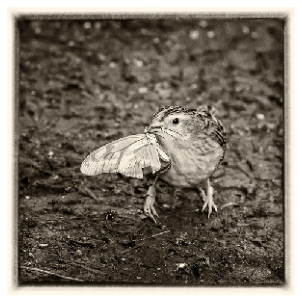

In [405]:
import random
#img_num=random.randint(1,5500)
if img_num is None:
    img_num = 10
    
img, image_topics_list =image_recognition_pipeline(img_model, img_label_dict, img_num )

In [406]:
#image_topics_list

In [407]:
# def get_progress_text():
#     return progress_text

In [408]:
# broad = True
# subtle = False
# contrary = False

In [430]:
# broad = False
# subtle = False
# contrary = True

In [431]:
#display_df = process_captioning_the_image(phrase_dict)
#display_df = process_captioning_the_image()

bar = st.progress(0)
status_text = st.empty()
progress_text = "Exploring"

#cand_df, image_topic_word, phrase_dict = generate_the_captions()
cand_df, image_topic_word, phrase_dict = generate_the_captions(bar )

status_text.text('Done!')
#st.balloons()


word is in word2vec
[('lizards', 0.7120301723480225), ('snake', 0.7016227841377258), ('snakes', 0.636357843875885), ('parrot', 0.6323928236961365), ('tortoise', 0.6307032704353333)]
lizards 0.28796982765197754
snake 0.29837721586227417
snakes 0.363642156124115
parrot 0.3676071763038635
tortoise 0.36929672956466675


In [432]:
#!ls data

In [433]:
#cand_df

In [434]:
# with open("data/" + 'word_to_phrase_dict.pickle', 'rb') as to_read:  
#     word_to_phrase_dict  =  pickle.load(to_read)      
# word_to_phrase_dict['dispope']

In [446]:

cand_df, best_captions_df, phrase_dict = process_captioning_the_image_part1(cand_df, image_topic_word, phrase_dict)

<ipython-input-300-9a4e40ee8091>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?


In [447]:
#best_captions_df

In [448]:
#cand_df

In [449]:
#phrase_dict['91df2c78-854a-11eb-a9e5-acde48001122']

In [450]:
#cand_df[cand_df['semantic_match']=='window']

In [451]:
#best_captions_df

In [452]:
img, best_captions_list, best_captions_df = process_captioning_the_image_part2(cand_df, best_captions_df, phrase_dict )

<ipython-input-300-9a4e40ee8091>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['caption'] = best_df.apply(lambda row: construct_caption_by_substitution(row, row['phonetic_match'],  row['semantic_match'], phrase_dict_, ), axis=1 )        # Is it not to pass a dictionary to a function?


In [453]:
#best_captions_df

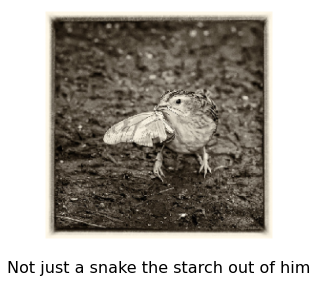

<ipython-input-302-12bec329cc17>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_captions_display_df['caption'] =best_captions_display_df['caption'].apply(lambda x: x.capitalize())


In [454]:
    
display_df = process_captioning_the_image_part3( img, best_captions_list, best_captions_df)


In [333]:
#image_topic_word

In [334]:
display_image()

### Streamlit code

### Non-streamlit code

In [90]:
#get_best_captions(cand_df)

In [91]:
#image_topic

In [92]:
#display_df

In [1]:
!jupyter nbconvert --to script amusemater_captioner_cleaned____.ipynb
with open('amusemater_captioner_cleaned____.py', 'r') as f:
    lines = f.readlines()
with open('amusemater_captioner_cleaned____.py', 'w') as f:
    for line in lines:
        if 'nbconvert --to script' in line:
            break
      #  elif ( not( '# In[' in line) and (']:' in line)) and ('\%matplotlib inline' not in line):
        else:
            f.write(line)

[NbConvertApp] WARNING | Config option `kernel_spec_manager_class` not recognized by `NbConvertApp`.
[NbConvertApp] Converting notebook amusemater_captioner_cleaned____.ipynb to script
[NbConvertApp] Writing 48534 bytes to amusemater_captioner_cleaned____.py


In [612]:
#display_df[display_df['dist_score'] == display_df['dist_score'].min()].sample(1)

In [579]:
#'dining_table'.replace('_', ' ')

'dining table'

In [545]:
word = "this is all I want"
word = word[0].upper() + word[1:]

'This is all I want'